In [2]:
import os
import numpy as np
import json
from wsrlib import pyart, radar2mat
from wsrdata.utils.bbox_utils import scale_XYWH_box
import matplotlib.pyplot as plt
import matplotlib.colors as pltc

NORMALIZERS = {
        'reflectivity':              pltc.Normalize(vmin=  -5, vmax= 35),
        'velocity':                  pltc.Normalize(vmin= -15, vmax= 15),
        'spectrum_width':            pltc.Normalize(vmin=   0, vmax= 10),
        'differential_reflectivity': pltc.Normalize(vmin=  -4, vmax= 8),
        'differential_phase':        pltc.Normalize(vmin=   0, vmax= 250),
        'cross_correlation_ratio':   pltc.Normalize(vmin=   0, vmax= 1.1)
}

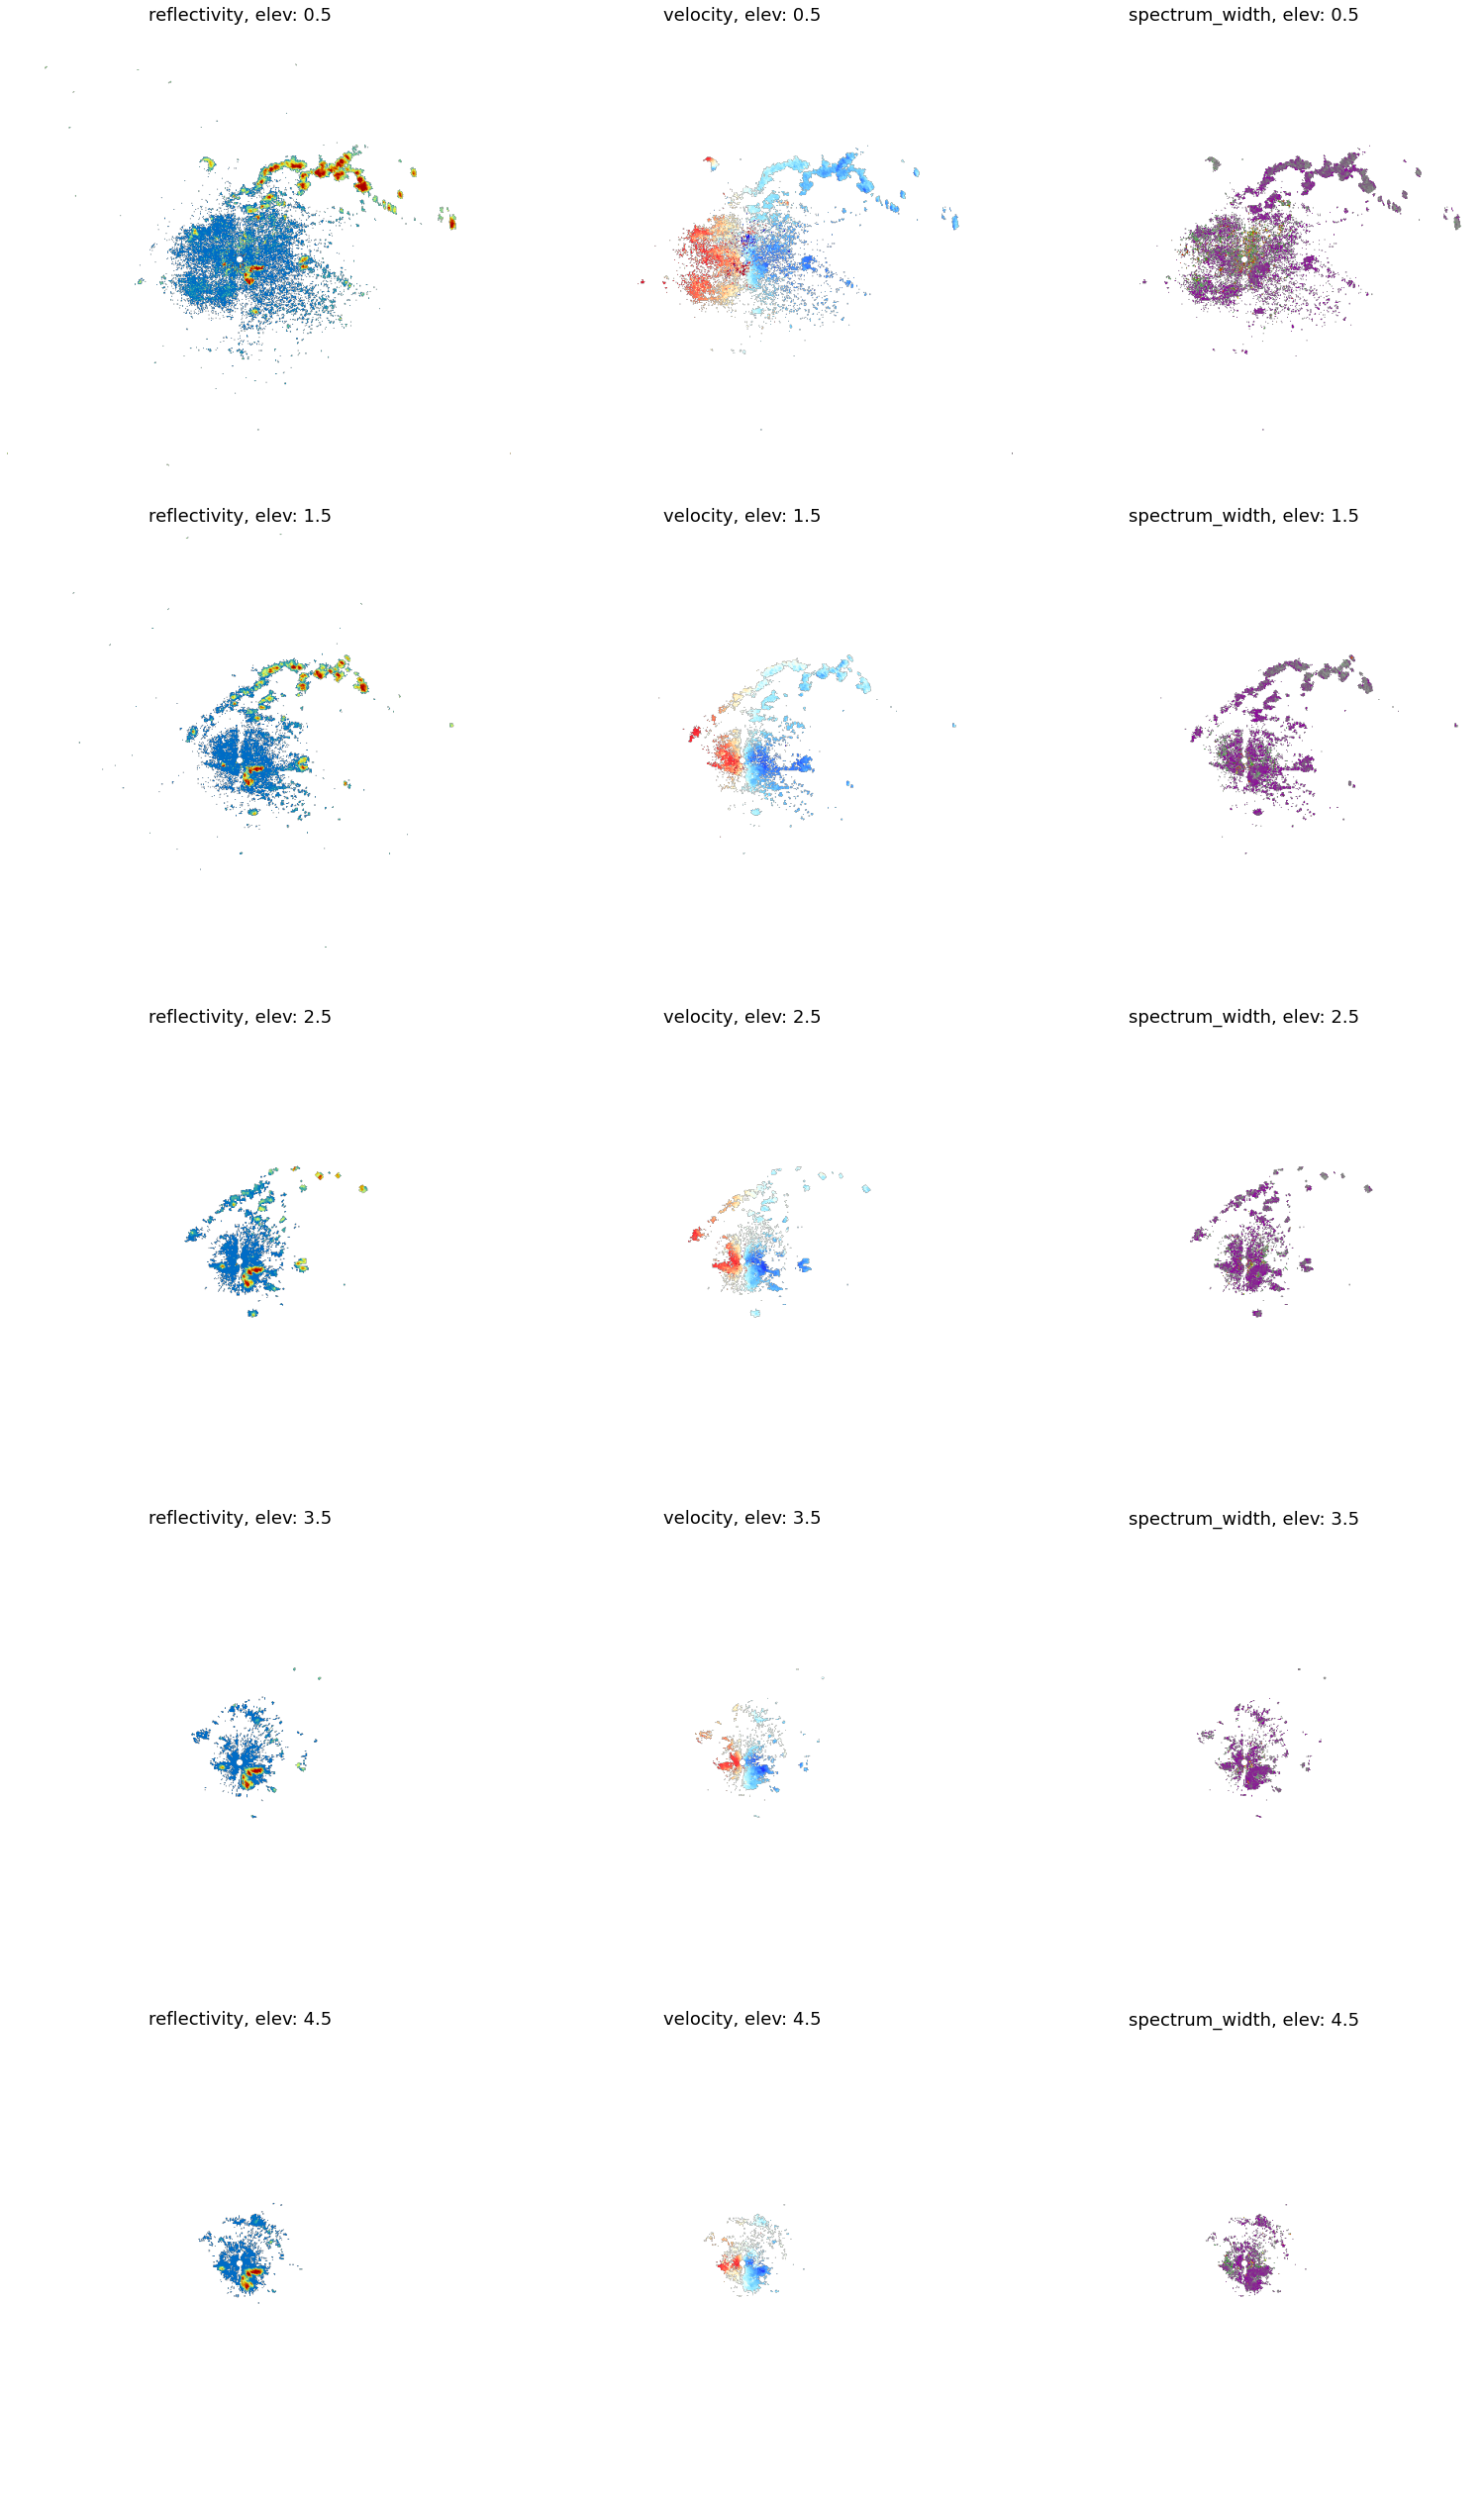

In [17]:
# Render and visualize a scan

SCAN = "KAMX20101024_111513_V03"
SCAN_FILE = f"/scratch2/wenlongzhao/roosts2021/libs/wsrdata/static/scans/scans/{SCAN[4:8]}/{SCAN[8:10]}/{SCAN[10:12]}/{SCAN[:4]}/{SCAN}.gz"
    # /scratch2/wenlongzhao/roosts2021/libs/wsrdata/static/scans/scans/2010/10/22/KAMX/KAMX20101022_105646_V03.gz
ATTRIBUTES = ["reflectivity", "velocity", "spectrum_width"]
ELEVATIONS = [0.5, 1.5, 2.5, 3.5, 4.5]

radar = pyart.io.read_nexrad_archive(SCAN_FILE)
data, fields, elevs, y, x = radar2mat(radar,
                                      ydirection="ij",
                                      fields=ATTRIBUTES,
                                      coords='cartesian',
                                      r_max=150000,
                                      dim=600,
                                      elevs=ELEVATIONS,)

fig, axs = plt.subplots(len(ELEVATIONS), len(ATTRIBUTES), figsize=(21, 35), constrained_layout=True)
# fig.tight_layout()
for i, attr in enumerate(ATTRIBUTES):
    for j, elev in enumerate(ELEVATIONS):
        subplt = axs[j, i]
        subplt.axis('off')
        subplt.set_title(f"{attr}, elev: {elev}", fontsize=18)
        cm = plt.get_cmap(pyart.config.get_field_colormap(attr))
        rgb = cm(NORMALIZERS[attr](data[i, j, :, :]))
        subplt.imshow(rgb, origin='lower')

plt.show()

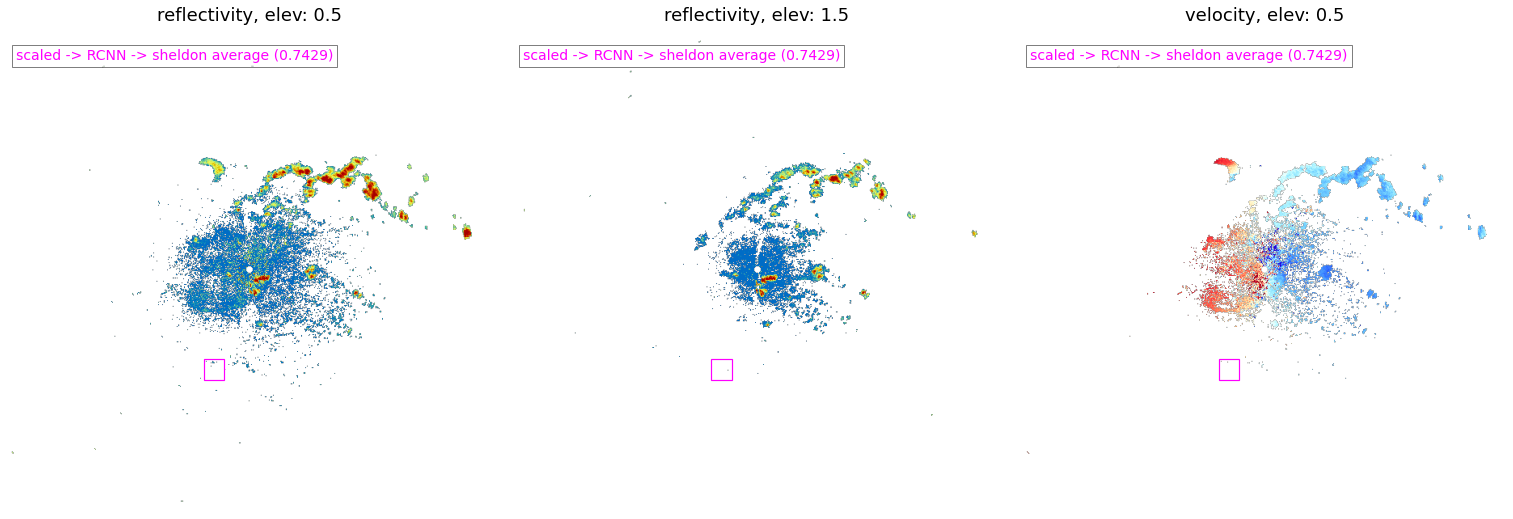

In [10]:
# Visualize an npy array with annotations from json

# define which scan to visualize, which json to be the source of annotations
SCAN = "KAMX20101024_112106_V03"
JSON_PATH = "/scratch2/wenlongzhao/roosts2021/libs/wsrdata/datasets/roosts_v0.0.1/roosts_v0.0.1.json"
OUTPUT_DIR = "/scratch2/wenlongzhao/roosts2021/libs/wsrdata/datasets/roosts_v0.0.1/visualization"

# colors for bboxes
color_array = [
    '#006400', # for not scaled boxes
    '#FF00FF', # scaled to RCNN then to user factor 0.7429 which is sheldon average
    '#800080',
    '#FFA500',
    '#FFFF00'
]

with open(JSON_PATH, "r") as f:
    dataset = json.load(f)
scan_to_id = {}
for scan in dataset["scans"]:
    scan_to_id[scan["key"]] = scan["id"]
scan = dataset["scans"][scan_to_id[SCAN]]
attributes = dataset["info"]["array_fields"]
elevations = dataset["info"]["array_elevations"]

array = np.load(os.path.join(dataset["info"]["array_dir"], scan["array_path"]))["array"]

fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)

for i, (attr, elev) in enumerate([("reflectivity", 0.5), ("reflectivity", 1.5), ("velocity", 0.5)]):
    subplt = axs[i]
    subplt.axis('off')
    subplt.set_title(f"{attr}, elev: {elev}", fontsize=18)
    cm = plt.get_cmap(pyart.config.get_field_colormap(attr))
    rgb = cm(NORMALIZERS[attr](array[attributes.index(attr), elevations.index(elev), :, :]))
    subplt.imshow(rgb, origin='lower')
    for annotation_id in scan["annotation_ids"]:
        bbox = dataset["annotations"][annotation_id]["bbox"]
        subplt.add_patch(
            plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                          fill=False,
                          edgecolor=color_array[1], 
                          linewidth=1.2)
        )
        subplt.text(10, 40, 'scaled -> RCNN -> sheldon average (0.7429)', 
                    bbox=dict(facecolor='white', alpha=0.5),fontsize=14, color=color_array[1])

plt.show()


if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
fig.savefig(os.path.join(OUTPUT_DIR, SCAN+".png"), bbox_inches = "tight")
plt.close(fig)

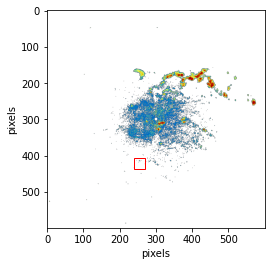

In [3]:
# Check ydirection

import pyart
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from wsrlib import radar2mat

SCAN = "KAMX20101024_112106_V03"
SCAN_FILE = f"/scratch2/wenlongzhao/roosts2021/libs/wsrdata/static/scans/scans/{SCAN[4:8]}/{SCAN[8:10]}/{SCAN[10:12]}/{SCAN[:4]}/{SCAN}.gz"

def xyr2bbox(x, y, r):
    xy = np.array((x - r, y - r))
    w = 2*r
    h = 2*r
    return xy, w, h

im_x, im_y, im_r = -22192.5, 61572.5, 7482.079258526
im_x = (im_x + 150000) * 600 / (2 * 150000)
im_y = (im_y + 150000) * 600 / (2 * 150000)
im_r = im_r * 600 / (2 * 150000)
radar = pyart.io.read_nexrad_archive(SCAN_FILE)

"""ydirection=ij"""
data, fields, elev, y, x = radar2mat(radar,
                                     coords='cartesian',
                                     ydirection='ij',
                                     dim=600, 
                                     r_max=150000)

cm = plt.get_cmap(pyart.config.get_field_colormap("reflectivity"))
rgb = cm(NORMALIZERS["reflectivity"](data[0,0,:,:]))
    
"""origin is default"""
plt.imshow(rgb)

# get bbox from x, y, r
xy, w, h = xyr2bbox(im_x, im_y, im_r)

# plot
rect = patches.Rectangle( xy, w, h, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.show()